# Adventure Works Sales Forecasting

## Desafios de Negócio:

- A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

- Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.

- Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 7?

- Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?

## 1. Imports e Configurações Iniciais

### 1.1. Instalação de Libs Externas

In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 4.0 MB/s eta 0:00:00


In [3]:
!pip install -U numba statsforecast datasetsforecast hierarchicalforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.2/508.2 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.3 MB/s eta 0:00:00


### 1.2. Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import snowflake.connector
import statsforecast
import xgboost as xgb
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, Naive
from statsforecast.utils import AirPassengers

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.evaluation import HierarchicalEvaluation, mse
from hierarchicalforecast.utils import aggregate

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

### 1.3. Configurações Iniciais

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### 1.4. Carregamento dos dados

In [7]:
# Configurações de conexão com o Snowflake
conn = snowflake.connector.connect(
    user='XXXX',
    password='XXXX',
    account='XXXX',
    warehouse='ACADEMY_WAREHOUSE',
    database='FEA24_6',
    schema='DBT_DSANCHES'
)

query_sql = """
with
    fct_sales as (
        select
            fk_sales_order
            , fk_product
            , fk_customer
            , fk_ship_address
            , dt_order
            , quantity
            , reason_name as order_reason
            , is_online_order
        from fea24_6.dbt_dsanches.fct_sales_orders
    ),

    dim_products as (
        select
            pk_product
            , product_name
            , category_name
            , subcategory_name
            , is_manufactured
        from fea24_6.dbt_dsanches.dim_products
    ),

    dim_regions as (
        select
            pk_address
            , state_province_name as state_province
            , country_region_name as country
        from fea24_6.dbt_dsanches.dim_regions
    ),

    dim_customers as (
        select
            pk_customer
            , pk_store as store_id
            , store_name
        from fea24_6.dbt_dsanches.dim_customers
    )

    select
        sales.fk_sales_order as order_id
        , sales.dt_order
        , cust.store_name
        , prod.category_name
        , prod.subcategory_name
        , prod.product_name
        , sales.quantity
        , sales.is_online_order
        , sales.order_reason
        , reg.state_province
        , reg.country
    from fct_sales sales
    left join dim_products prod
        on sales.fk_product = prod.pk_product
    left join dim_regions reg
        on sales.fk_ship_address = reg.pk_address
    left join dim_customers cust
        on sales.fk_customer = cust.pk_customer;
"""

df = pd.read_sql(query_sql, conn)

conn.close()

path = '/content/sales_orders.csv'
df.to_csv(path, index=False)

### 1.5. Variáveis Globais

In [8]:
HORIZON = 3

### 1.6. Funções Auxiliares

In [9]:
def rmse(y_true, y_pred):
    """
    Calcula o Root Mean Squared Error (RMSE) entre os valores reais e as previsões.

    Parameters:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores previstos.

    Returns:
    float: O valor do RMSE.
    """
    return np.sqrt(mse(y_true, y_pred))

def mean_absolute_error(y_true, y_pred):
    """
    Calcula o Mean Absolute Error (MAE) entre os valores reais e as previsões.

    Parameters:
    y_true (array-like): Valores reais.
    y_pred (array-like): Valores previstos.

    Returns:
    float: O valor do MAE.
    """
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calcula o MAPE (Mean Absolute Percentage Error).

    Parâmetros:
    y_true (array-like): Valores reais (verdadeiros).
    y_pred (array-like): Valores previstos.

    Retorna:
    float: O MAPE calculado.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0

    mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    return mape

## 2. Checagens Iniciais e Pré-Processamento

In [10]:
df_sales_orders = df.copy()
df_sales_orders.head()

,ORDER_ID,DT_ORDER,STORE_NAME,CATEGORY_NAME,SUBCATEGORY_NAME,PRODUCT_NAME,QUANTITY,IS_ONLINE_ORDER,ORDER_REASON,STATE_PROVINCE,COUNTRY
0,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 42",1,False,Not Informed,Georgia,United States
1,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 44",3,False,Not Informed,Georgia,United States
2,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 48",1,False,Not Informed,Georgia,United States
3,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",1,False,Not Informed,Georgia,United States
4,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 42",1,False,Not Informed,Georgia,United States


### 2.1. Descrição das Colunas e Tamanho do Dataset

| Coluna | Descrição |
| :----- | :-------- |
| order_id | ID do pedido |
| dt_order | Data da compra |
| store_name | Nome da loja onde ocorreu a transação |
| category_name | Categoria do produto comprado |
| subcategory_name | Subcategoria do produto comprado |
| product_name | Nome do produto |
| quantity | Quantidade comprada do produto |
| is_online_order | Flag que indica se a compra foi online ou na loja |
| order_reason | Motivo da compra |
| state_province | Estado ou Província do Cliente |
| country | País do Cliente |

In [11]:
print(f'Qtd Linhas: {df_sales_orders.shape[0]}')
print(f'Qtd Colunas: {df_sales_orders.shape[1]}')

Qtd Linhas: 121317
Qtd Colunas: 11


### 2.2. Renomeando Colunas

In [12]:
df_sales_orders.columns = df_sales_orders.columns.str.lower()
df_sales_orders.columns

Index(['order_id', 'dt_order', 'store_name', 'category_name',
       'subcategory_name', 'product_name', 'quantity', 'is_online_order',
       'order_reason', 'state_province', 'country'],
      dtype='object')

### 2.3. Validação dos Tipos de Dados

In [ ]:
df_sales_orders.dtypes

,0
order_id,int64
dt_order,object
store_name,object
category_name,object
subcategory_name,object
product_name,object
quantity,int64
is_online_order,bool
order_reason,object
state_province,object


### 2.4. Conversão de Tipos

In [13]:
df_sales_orders['dt_order'] = pd.to_datetime(df_sales_orders['dt_order'])
df_sales_orders[['dt_order']].dtypes

,0
dt_order,datetime64[ns]


### 2.5. Validação dos NA

In [ ]:
df_sales_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_id          121317 non-null  int64         
 1   dt_order          121317 non-null  datetime64[ns]
 2   store_name        60919 non-null   object        
 3   category_name     121317 non-null  object        
 4   subcategory_name  121317 non-null  object        
 5   product_name      121317 non-null  object        
 6   quantity          121317 non-null  int64         
 7   is_online_order   121317 non-null  bool          
 8   order_reason      121317 non-null  object        
 9   state_province    121317 non-null  object        
 10  country           121317 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(7)
memory usage: 9.4+ MB


In [ ]:
df_sales_orders.isna().sum()

,0
order_id,0
dt_order,0
store_name,60398
category_name,0
subcategory_name,0
product_name,0
quantity,0
is_online_order,0
order_reason,0
state_province,0


In [ ]:
# Percentual de nulos
round(df_sales_orders.isna().sum() / df_sales_orders.shape[0] * 100, 2)

,0
order_id,0.00
dt_order,0.00
store_name,49.79
category_name,0.00
subcategory_name,0.00
product_name,0.00
quantity,0.00
is_online_order,0.00
order_reason,0.00
state_province,0.00


### 2.5. Preenchimento dos NAs

In [14]:
# Verificando se os nulos em 'store_name' são compras online (is_online_order = True)
store_na_count = df_sales_orders[(df_sales_orders['store_name'].isnull()) & (df_sales_orders['is_online_order'] == True)].shape[0]
print(f"Contagem de registros onde 'store_name' é nulo e 'is_online_order' é True: {store_na_count}")


Contagem de registros onde 'store_name' é nulo e 'is_online_order' é True: 60398


Logo, todos os registros nulos de store_name são aqueles referentes a compras online. Dessa forma, vamos substituir os valores nulos por 'Online Store'.

In [15]:
df_sales_orders['store_name'] = df_sales_orders['store_name'].fillna('Online Store')

## 3. Estatística Descritiva

### 3.1. Seleção de tipos de dados

In [16]:
num_vars = df_sales_orders.select_dtypes(include=['int64'])
cat_vars = df_sales_orders.select_dtypes(exclude=['int64'])

In [ ]:
num_vars.head()

,order_id,quantity
0,43659,1
1,43659,3
2,43659,1
3,43659,1
4,43659,1


In [ ]:
cat_vars.head()

,dt_order,store_name,category_name,subcategory_name,product_name,is_online_order,order_reason,state_province,country
0,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 42",False,Not Informed,Georgia,United States
1,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 44",False,Not Informed,Georgia,United States
2,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 48",False,Not Informed,Georgia,United States
3,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",False,Not Informed,Georgia,United States
4,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 42",False,Not Informed,Georgia,United States


### 3.2. Variáveis Numéricas

In [ ]:
num_vars['quantity'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,quantity
count,121317.000000
mean,2.266080
std,2.491323
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
95%,7.000000
99%,12.000000
max,44.000000


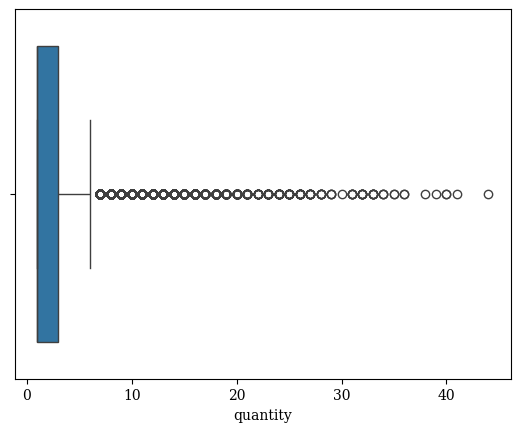

In [ ]:
sns.boxplot(
    data=num_vars,
    x='quantity'
);

### 3.3. Variáveis Categóricas

In [ ]:
# Distribuição de lojas
print(df_sales_orders['store_name'].value_counts())

store_name
Online Store                          60398
Vigorous Exercise Company               530
Larger Cycle Shop                       482
Retail Mall                             451
Rapid Bikes                             446
                                      ...  
Retail Cycle Shop                         1
Imported and Domestic Cycles              1
Recreation Supplies                       1
Chain and Chain Tool Distributions        1
Seats and Saddles Company                 1
Name: count, Length: 634, dtype: int64


category_name
Accessories    41194
Bikes          40031
Clothing       21394
Components     18698
Name: count, dtype: int64


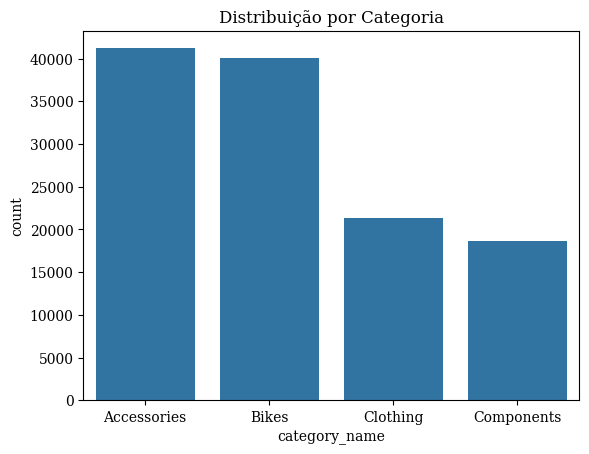

In [ ]:
# Distribuição da categoria de produto
print(df_sales_orders['category_name'].value_counts())

plt.figure()
sns.countplot(data=df_sales_orders, x='category_name', order=df_sales_orders['category_name'].value_counts().index)
plt.title('Distribuição por Categoria')
plt.show()

In [ ]:
# Distribuição por subcategoria de produto
print(df_sales_orders['subcategory_name'].value_counts())

subcategory_name
Road Bikes           20944
Tires and Tubes      17495
Mountain Bikes       12457
Helmets               9180
Bottles and Cages     8425
Jerseys               7191
Touring Bikes         6630
Road Frames           4713
Mountain Frames       4477
Gloves                3605
Caps                  3382
Shorts                2610
Fenders               2121
Wheels                1904
Handlebars            1531
Pedals                1517
Vests                 1438
Socks                 1429
Touring Frames        1428
Cleaners              1327
Hydration Packs       1074
Tights                 977
Saddles                840
Bike Racks             796
Bib-Shorts             762
Cranksets              423
Derailleurs            402
Brakes                 379
Bottom Brackets        368
Pumps                  267
Headsets               266
Locks                  260
Chains                 250
Bike Stands            249
Forks                  200
Name: count, dtype: int64


In [ ]:
# Distribuição por tipo de compra
print(df_sales_orders['is_online_order'].value_counts())

is_online_order
False    60919
True     60398
Name: count, dtype: int64


order_reason
Not Informed                 67348
Price                        47733
On Promotion                  2048
Manufacturer                  1818
Review                        1640
Television  Advertisement      730
Name: count, dtype: int64


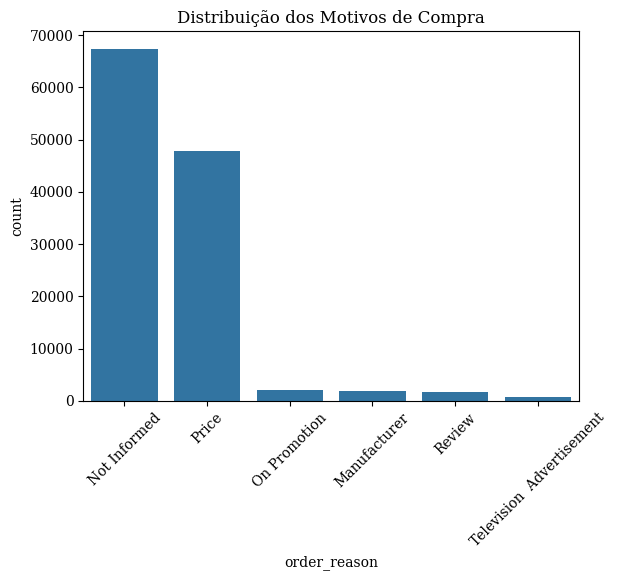

In [ ]:
# Distribuição por motivo de compra
print(df_sales_orders['order_reason'].value_counts())

plt.figure()
sns.countplot(data=df_sales_orders, x='order_reason', order=df_sales_orders['order_reason'].value_counts().index)
plt.title('Distribuição dos Motivos de Compra')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Distribuição por Estado/Província
print(df_sales_orders['state_province'].value_counts())

state_province
California          19168
Washington          10675
England             10426
British Columbia     9949
New South Wales      6999
                    ...  
Manitoba               53
Alabama                43
Montana                42
Rhode Island           18
Maryland                4
Name: count, Length: 70, dtype: int64


country
United States     60153
Canada            19064
Australia         15058
United Kingdom    10426
France             9088
Germany            7528
Name: count, dtype: int64


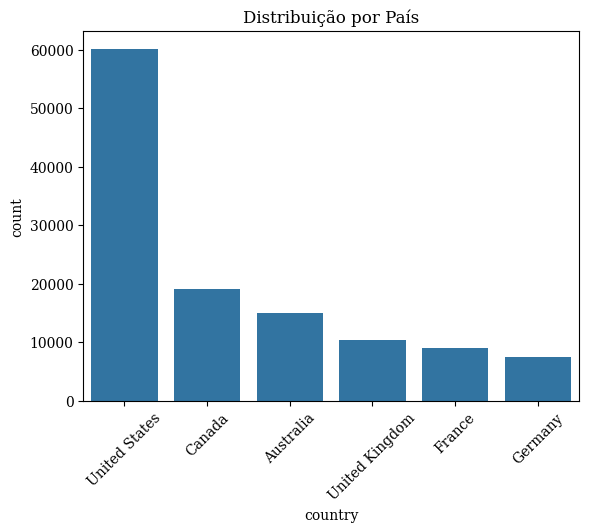

In [ ]:
# Distribuição por País
print(df_sales_orders['country'].value_counts())

plt.figure()
sns.countplot(data=df_sales_orders, x='country', order=df_sales_orders['country'].value_counts().index)
plt.title('Distribuição por País')
plt.xticks(rotation=45)
plt.show()

### 3.4. Análise Conjunta

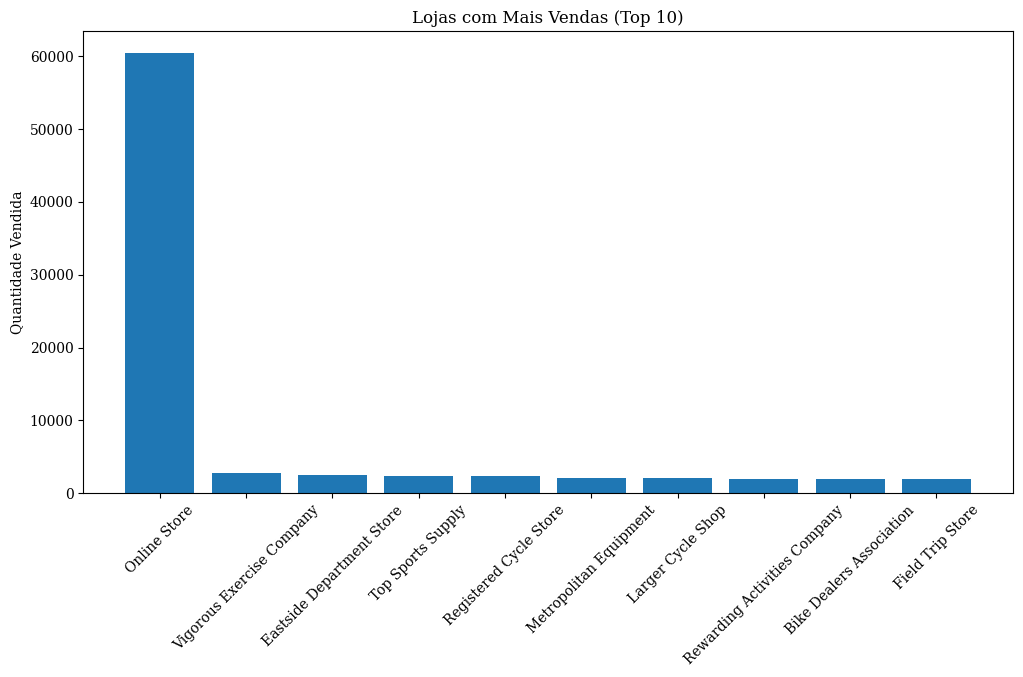

In [17]:
store_orders = df_sales_orders.groupby('store_name')['quantity'].sum().reset_index()
store_orders = store_orders.sort_values(by='quantity', ascending=False)
best_stores = store_orders.head(10)

plt.figure(figsize=(12, 6))
plt.bar(best_stores['store_name'], best_stores['quantity'])
plt.title('Lojas com Mais Vendas (Top 10)')
plt.ylabel('Quantidade Vendida')
plt.xticks(rotation=45)
plt.show()

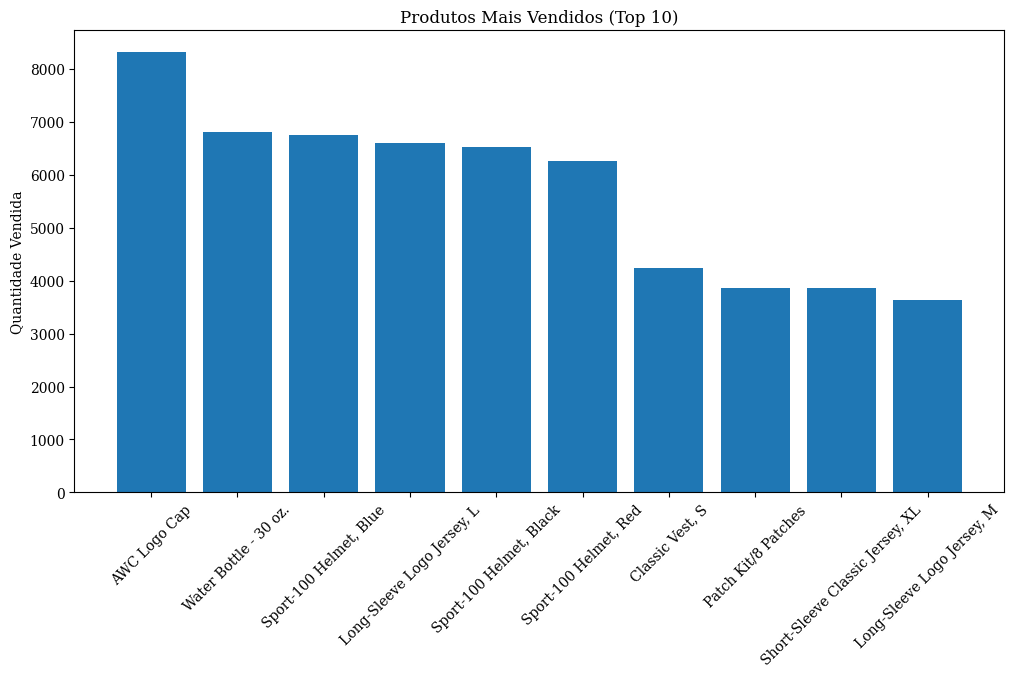

In [18]:
product_orders = df_sales_orders.groupby('product_name')['quantity'].sum().reset_index()
product_orders = product_orders.sort_values(by='quantity', ascending=False)
best_products = product_orders.head(10)

plt.figure(figsize=(12, 6))
plt.bar(best_products['product_name'], best_products['quantity'])
plt.title('Produtos Mais Vendidos (Top 10)')
plt.ylabel('Quantidade Vendida')
plt.xticks(rotation=45)
plt.show()

### 3.5. Análise Temporal

Nessa etapa, vamos agrupar os dados por mês-ano e verificar se existe tendência e sazonalidade nos dados.

In [19]:
monthly_sales = df_sales_orders.copy()
monthly_sales = monthly_sales.groupby(pd.Grouper(key='dt_order', freq='M')).sum()

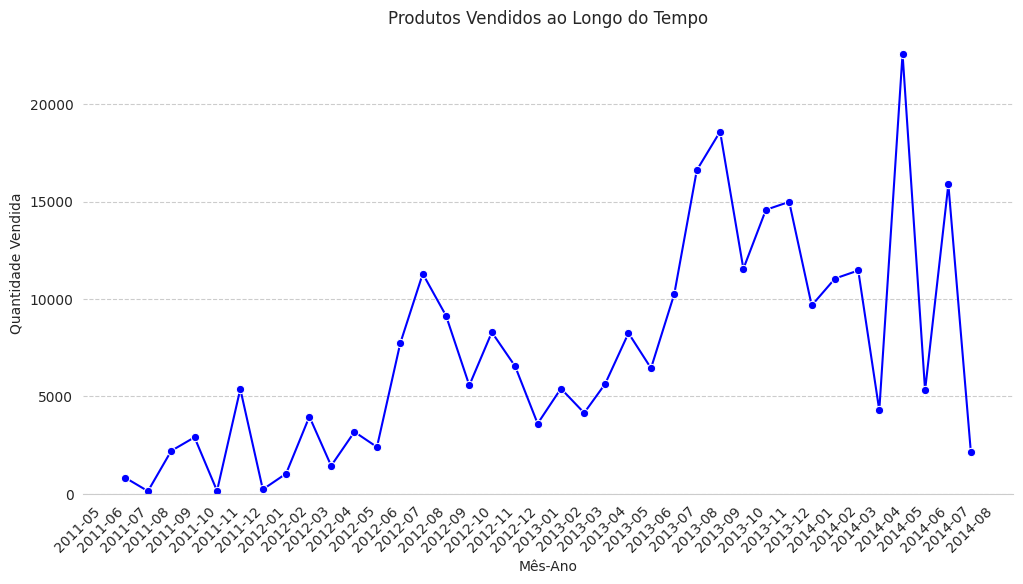

In [20]:
plt.figure(figsize=(12, 6))

sns.set_style('whitegrid', {'axes.grid': True,
                            'grid.linestyle': '--',
                            'axes.axisbelow': True})

sns.lineplot(
    x='dt_order',
    y='quantity',
    data=monthly_sales.query('dt_order > "2011-01-01"'),
    marker='o',
    color='blue'
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45, ha='right')

plt.title('Produtos Vendidos ao Longo do Tempo')
plt.xlabel('Mês-Ano')
plt.ylabel('Quantidade Vendida')
plt.ylim(0, None)
plt.grid(axis='x')
sns.despine(left=True)

plt.show()


Nota-se uma tendência de crescimento nas vendas nos meses de junho a agosto, seguida de uma tendência de queda nos meses subsequentes.

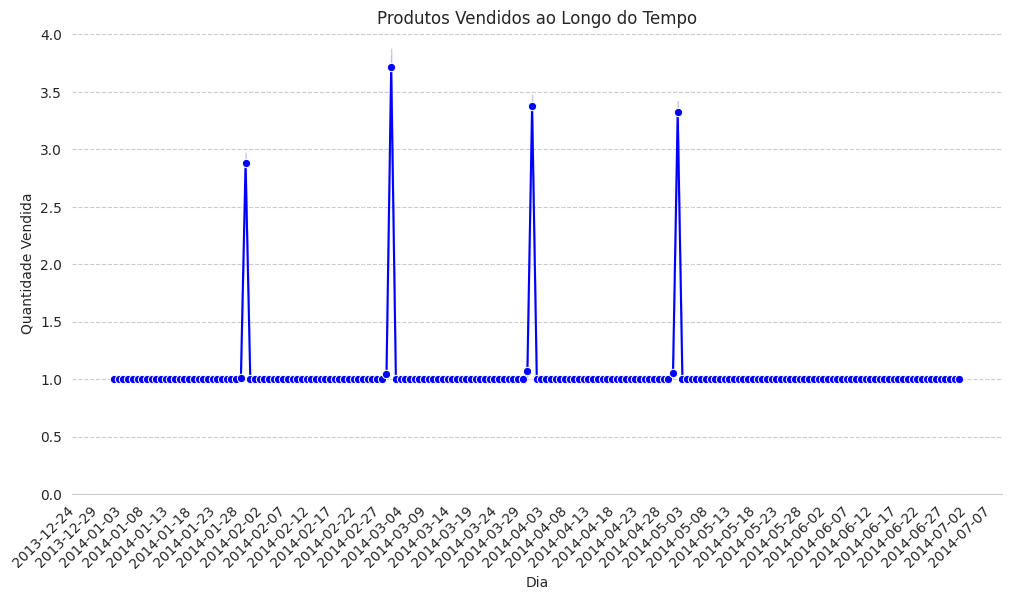

In [21]:
plt.figure(figsize=(12, 6))

sns.set_style('whitegrid', {'axes.grid': True,
                            'grid.linestyle': '--',
                            'axes.axisbelow': True})

sns.lineplot(
    x='dt_order',
    y='quantity',
    data=df_sales_orders.query('dt_order >= "2014-01-01"'),
    marker='o',
    color='blue'
)

# Ajusta para mostrar uma data a cada x dias
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
sns.despine(left=True)

plt.title('Produtos Vendidos ao Longo do Tempo')
plt.xlabel('Dia')
plt.ylabel('Quantidade Vendida')
plt.ylim(0, None)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')

plt.show()

Levando em consideração as vendas do último ano (2014), nota-se a presença de picos de vendas no início dos meses de fevereiro, março, abril e maio.

<Figure size 640x480 with 0 Axes>

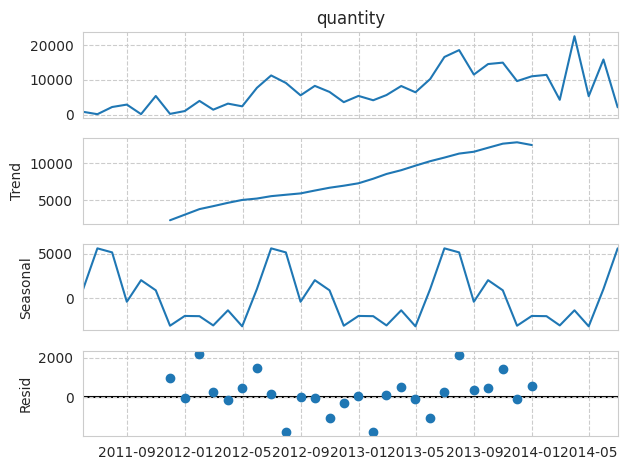

In [22]:
# Decomposição de vendas
results = seasonal_decompose(monthly_sales['quantity'], model='additive', period=12)

fig = plt.figure()
fig = results.plot()

In [23]:
# Teste de estacionariedade
result = adfuller(monthly_sales['quantity'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -1.9275875463949135
p-value: 0.31919640099182334


Entre os produtos vendidos pela empresa, aquele que apresentou maior demanda foi o **AWC Logo Cap**, com mais de 8.000 unidades vendidas no período de 2011 a 2014. Portanto, será realizada uma análise de sazonalidade específica para esse produto.

In [24]:
product_sales = df_sales_orders[df_sales_orders['product_name'] == 'AWC Logo Cap']
product_sales = product_sales.groupby(product_sales['dt_order'].dt.to_period('M')).agg({'quantity': 'sum'}).reset_index()

In [25]:
product_sales.shape

(35, 2)

In [26]:
product_sales.head(35)

,dt_order,quantity
0,2011-05,40
1,2011-07,103
2,2011-08,137
3,2011-10,240
4,2011-12,25
5,2012-01,153
6,2012-02,48
7,2012-03,125
8,2012-04,114
9,2012-05,215


In [27]:
product_sales.describe()

,quantity
count,35.000000
mean,237.457143
std,149.650444
min,25.000000
25%,130.000000
50%,215.000000
75%,332.000000
max,663.000000


In [28]:
product_sales['dt_order'] = product_sales['dt_order'].dt.to_timestamp()

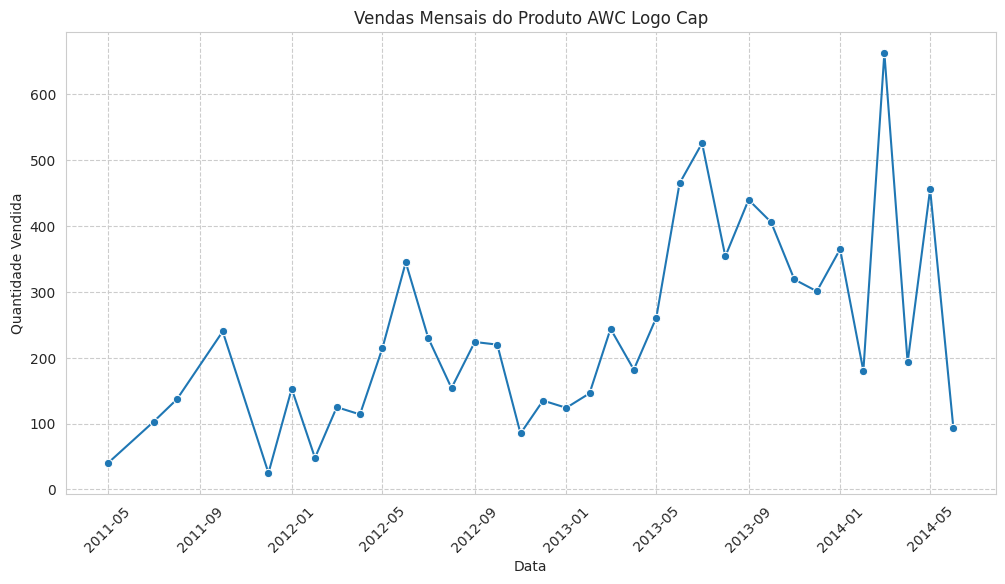

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=product_sales, x='dt_order', y='quantity', marker='o')
plt.title('Vendas Mensais do Produto AWC Logo Cap')
plt.xlabel('Data')
plt.ylabel('Quantidade Vendida')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

<Figure size 640x480 with 0 Axes>

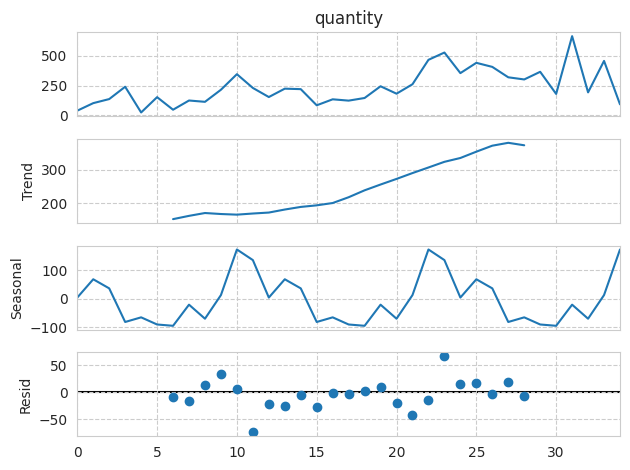

In [30]:
# Decomposição de vendas
results_awc = seasonal_decompose(product_sales['quantity'], model='additive', period=12)

fig = plt.figure()
fig = results_awc.plot()

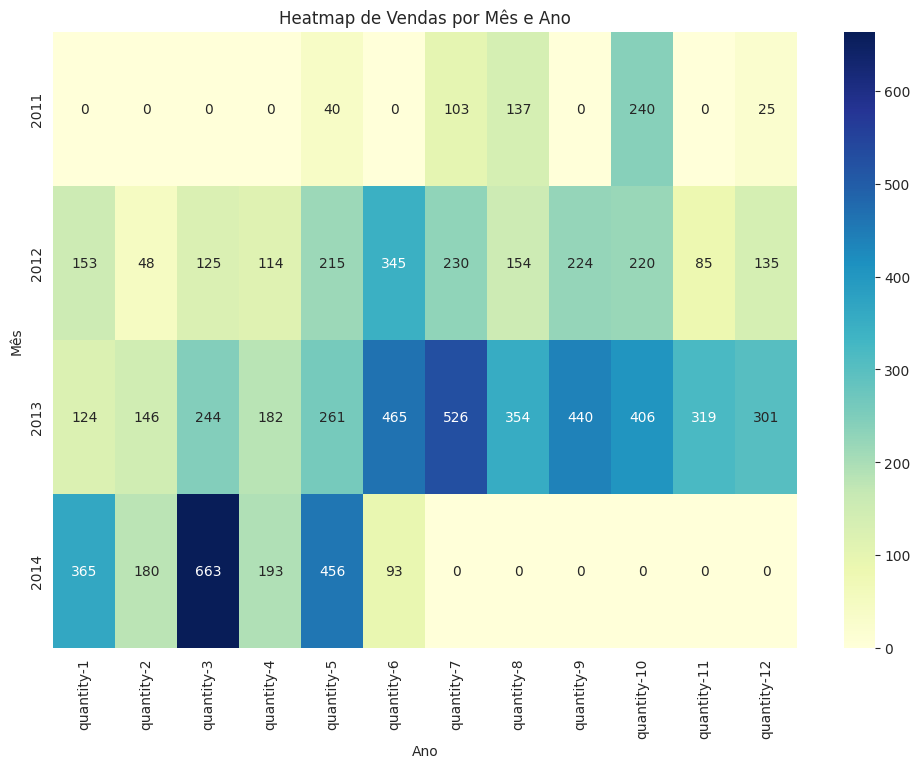

In [31]:
product_sales['month'] = product_sales['dt_order'].dt.month
product_sales['year'] = product_sales['dt_order'].dt.year
heatmap_data = product_sales.groupby(['year', 'month']).agg({'quantity': 'sum'}).unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='g')
plt.title('Heatmap de Vendas por Mês e Ano')
plt.xlabel('Ano')
plt.ylabel('Mês')
plt.show()

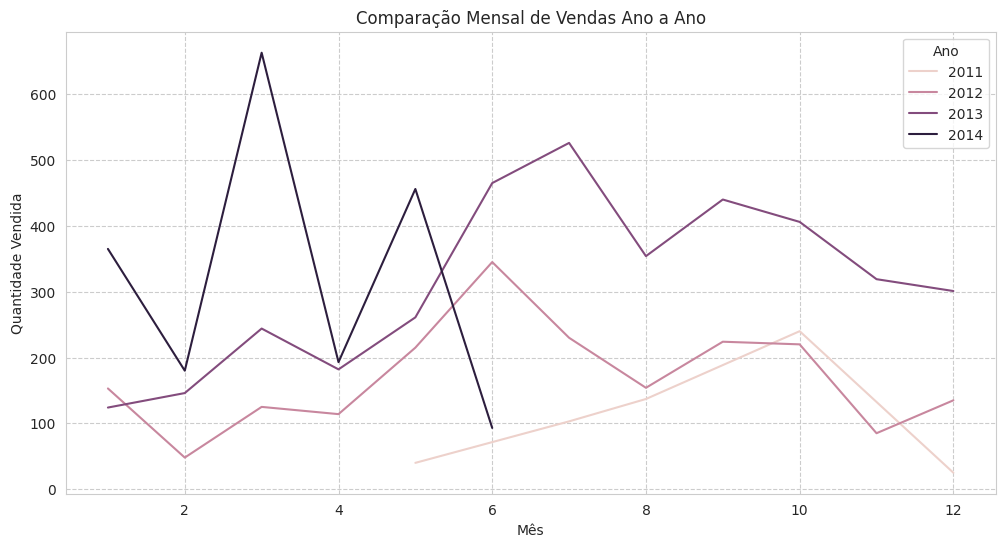

In [32]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=product_sales, x='month', y='quantity', hue='year')
plt.title('Comparação Mensal de Vendas Ano a Ano')
plt.xlabel('Mês')
plt.ylabel('Quantidade Vendida')
plt.legend(title='Ano')
plt.grid(True)
plt.show()

## 4. Filtragem de Features

Nessa etapa, os dados serão preparados para modelagem. Considerando que um dos objetivos dessa análise é prever a demanda de produtos por loja, a aplicação de séries temporais hierárquicas representa uma ótima solução para este problema. Portanto, vamos filtrar as features de interesse para o modelo e organizar os dados em suas respectivas hierarquias, conforme abaixo:

1. country
  2. state_province
    3. store_name
        4. product_name

In [33]:
df_features = df_sales_orders.copy()
df_features.head()

,order_id,dt_order,store_name,category_name,subcategory_name,product_name,quantity,is_online_order,order_reason,state_province,country
0,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 42",1,False,Not Informed,Georgia,United States
1,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 44",3,False,Not Informed,Georgia,United States
2,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 48",1,False,Not Informed,Georgia,United States
3,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",1,False,Not Informed,Georgia,United States
4,43659,2011-05-31,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 42",1,False,Not Informed,Georgia,United States


In [34]:
df_features = df_features[['dt_order', 'store_name', 'product_name', 'state_province', 'country', 'quantity']]
df_features.head()

,dt_order,store_name,product_name,state_province,country,quantity
0,2011-05-31,Better Bike Shop,"Mountain-100 Black, 42",Georgia,United States,1
1,2011-05-31,Better Bike Shop,"Mountain-100 Black, 44",Georgia,United States,3
2,2011-05-31,Better Bike Shop,"Mountain-100 Black, 48",Georgia,United States,1
3,2011-05-31,Better Bike Shop,"Mountain-100 Silver, 38",Georgia,United States,1
4,2011-05-31,Better Bike Shop,"Mountain-100 Silver, 42",Georgia,United States,1


## 5. Feature Enginnering

In [35]:
df_features['year_month'] = pd.to_datetime(df_features['dt_order']).dt.to_period('M').dt.to_timestamp()

In [36]:
# Agrupando dados por ano-mês
series_grouped = (
    df_features.groupby(['year_month', 'product_name', 'store_name', 'state_province', 'country'])['quantity'].sum()
    .reset_index()
)
series_grouped.head()

,year_month,product_name,store_name,state_province,country,quantity
0,2011-05-01,AWC Logo Cap,Area Bike Accessories,California,United States,3
1,2011-05-01,AWC Logo Cap,Better Bike Shop,Georgia,United States,2
2,2011-05-01,AWC Logo Cap,Bike Dealers Association,New Mexico,United States,6
3,2011-05-01,AWC Logo Cap,Bike Rims Company,Mississippi,United States,2
4,2011-05-01,AWC Logo Cap,First Bike Store,Missouri,United States,2


### 5.1. Séries Temporais Hierárquicas

A implementação do HierarchicalForecast requer tags, isto é, um dicionário que descreve a composição de cada nível. Portanto, precisamos declarar essas tags. Para isso, vamos usar a função aggregate dessa mesma biblioteca.

A função aggregate é usada para agregar os dados de acordo com as hierarquias definidas. Isso cria múltiplos níveis de agregação das séries temporais, correspondendo às diferentes granularidades definidas em hierarchies.

Teremos como resultado:
- **agg_series_df:** Contém os dados agregados em diferentes níveis, prontos para serem utilizados em modelos de previsão hierárquica.
- **sum_matrix_df:** Representa as somas de cada nível da hierarquia (informações de séries agregadas).
- **tags:** Tags que indicam a qual hierarquia cada linha pertence.

In [37]:
# Padronizando variáveis para modelos de séries temporais
series_grouped = series_grouped.rename(columns={'year_month': 'ds', 'quantity': 'y'})


In [38]:
# declarando as hierarquias
hierarchies = [
    ['country'],
    ['country', 'state_province'],
    ['country', 'state_province', 'store_name'],
    ['country', 'state_province', 'store_name', 'product_name']
]

agg_series_df, sum_matrix_df, tags = aggregate(series_grouped, hierarchies)
agg_series_df = agg_series_df.reset_index()

In [39]:
agg_series_df.head()

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,61
2,Australia,2011-07-01,68
3,Australia,2011-08-01,53
4,Australia,2011-09-01,64


## 6. Modelos

### 6.1. AutoARIMA e Naive

#### Separação de Treino e Teste:

In [40]:
Y_test_temp = agg_series_df.groupby('unique_id').tail(HORIZON)
Y_train_temp = agg_series_df.drop(Y_test_temp.index)

In [41]:
Y_train_temp.head()

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,61
2,Australia,2011-07-01,68
3,Australia,2011-08-01,53
4,Australia,2011-09-01,64


#### Previsões:

In [43]:
fcst = StatsForecast(
    df=Y_train_temp,
    models=[AutoARIMA(season_length=12), Naive(), ],
    freq = 'MS',
    n_jobs=-1
)

In [44]:
Y_hat_df = fcst.forecast(h=HORIZON,  fitted=True)

In [45]:
Y_hat_df.head()

,ds,AutoARIMA,Naive
unique_id,,,
Australia,2014-04-01,1676.000610,1477.0
Australia,2014-05-01,1158.793579,1477.0
Australia,2014-06-01,1532.609741,1477.0
Australia/New South Wales,2014-04-01,875.626221,764.0
Australia/New South Wales,2014-05-01,477.566681,764.0


In [ ]:
Y_test_temp.head()

,unique_id,ds,y
35,Australia,2014-04-01,1057
36,Australia,2014-05-01,2090
37,Australia,2014-06-01,357
73,Canada,2014-04-01,649
74,Canada,2014-05-01,2673


In [ ]:
Y_train_temp.head()

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,61
2,Australia,2011-07-01,68
3,Australia,2011-08-01,53
4,Australia,2011-09-01,64


#### Avaliação do Desempenho:

In [46]:
(predicts := Y_hat_df.merge(Y_test_temp, on=['ds', 'unique_id']))
predicts

,ds,unique_id,AutoARIMA,Naive,y
0,2014-04-01,Australia,1676.000610,1477.0,1057
1,2014-05-01,Australia,1158.793579,1477.0,2090
2,2014-06-01,Australia,1532.609741,1477.0,357
3,2014-04-01,Australia/New South Wales,875.626221,764.0,476
4,2014-05-01,Australia/New South Wales,477.566681,764.0,1178
...,...,...,...,...,...
11001,2013-08-01,"United States/Wyoming/Great Bikes /Women's Mountain Shorts, S",18.000000,18.0,14
11002,2012-08-01,"United States/Wyoming/Great Bikes /Women's Tights, S",5.000000,5.0,5
11003,2013-08-01,United States/Wyoming/Major Sport Suppliers,1.000000,1.0,1
11004,2011-10-01,"United States/Wyoming/Some Discount Store/Mountain-100 Black, 44",2.000000,2.0,4


In [47]:
Y_lastmonth = Y_test_temp.set_index('unique_id')

In [48]:
metrics_per_category = []

for unique_id, group in Y_hat_df.groupby(Y_hat_df.index):
  true_values = Y_lastmonth.loc[Y_lastmonth.index == unique_id, 'y']
  autoarima_values = group['AutoARIMA']
  naive_values = group['Naive']

  mae_autoarima = mean_absolute_error(true_values, autoarima_values)
  mse_autoarima = rmse(true_values, autoarima_values)
  mae_naive = mean_absolute_error(true_values, naive_values)
  mse_naive = rmse(true_values, naive_values)

  result = {
      'unique_id': unique_id,
      'MAE_AutoARIMA': mae_autoarima,
      'MSE_AutoARIMA': mse_autoarima,
      'MAE_Naive': mae_naive,
      'MSE_Naive': mse_naive
  }
  metrics_per_category.append(result)

metrics_df = pd.DataFrame(metrics_per_category)
display(metrics_df)

,unique_id,MAE_AutoARIMA,MSE_AutoARIMA,MAE_Naive,MSE_Naive
0,Australia,908.605591,936.725755,717.666667,776.008806
1,Australia/New South Wales,582.045522,596.580108,439.000000,459.189503
2,Australia/New South Wales/Bike Part Wholesalers,46.000000,53.820690,46.000000,53.820690
3,Australia/New South Wales/Bike Part Wholesalers/AWC Logo Cap,2.000000,2.160247,2.000000,2.160247
4,Australia/New South Wales/Bike Part Wholesalers/Bike Wash - Dissolver,1.666667,1.732051,1.666667,1.732051
...,...,...,...,...,...
9604,"United States/Wyoming/Great Bikes /Women's Tights, S",2.000000,2.449490,2.000000,2.449490
9605,United States/Wyoming/Major Sport Suppliers,0.333333,0.577350,0.333333,0.577350
9606,United States/Wyoming/Some Discount Store,1.000000,1.000000,7.000000,7.000000
9607,"United States/Wyoming/Some Discount Store/Mountain-100 Black, 44",1.333333,1.414214,1.333333,1.414214


In [49]:
# Comparando resultados MAE
display(metrics_df['MAE_AutoARIMA'].sum().round(2))
display(metrics_df['MAE_Naive'].sum().round(2))
display(metrics_df['MAE_AutoARIMA'].mean().round(2))
display(metrics_df['MAE_Naive'].mean().round(2))

65768.68

70264.67

6.84

7.31

In [50]:
# Comparando resultados MSE
display(metrics_df['MSE_AutoARIMA'].sum().round(2))
display(metrics_df['MSE_Naive'].sum().round(2))
display(metrics_df['MSE_AutoARIMA'].mean().round(2))
display(metrics_df['MSE_Naive'].mean().round(2))

73375.32

77071.43

7.64

8.02

Os resultados mostram que o modelo AutoARIMA tem um desempenho melhor em termos de erro absoluto total e médio (MAE) em comparação ao modelo Naive, o mesmo vale em termos de erro quadrático total e médio (MSE). Isso sugere que o AutoARIMA fornece previsões mais precisas para a demanda do que o método Naive.

#### Demanda Países x Províncias (EUA)

In [51]:
demand_agg = predicts.copy()
demand_agg.head()

,ds,unique_id,AutoARIMA,Naive,y
0,2014-04-01,Australia,1676.000610,1477.0,1057
1,2014-05-01,Australia,1158.793579,1477.0,2090
2,2014-06-01,Australia,1532.609741,1477.0,357
3,2014-04-01,Australia/New South Wales,875.626221,764.0,476
4,2014-05-01,Australia/New South Wales,477.566681,764.0,1178


In [52]:
# Desagregar os níveis hierárquicos em colunas
demand_agg[['country', 'state_province', 'store_name', 'product_name']] = demand_agg['unique_id'].str.split('/', expand=True)
demand_agg.head()

,ds,unique_id,AutoARIMA,Naive,y,country,state_province,store_name,product_name
0,2014-04-01,Australia,1676.000610,1477.0,1057,Australia,None,None,None
1,2014-05-01,Australia,1158.793579,1477.0,2090,Australia,None,None,None
2,2014-06-01,Australia,1532.609741,1477.0,357,Australia,None,None,None
3,2014-04-01,Australia/New South Wales,875.626221,764.0,476,Australia,New South Wales,None,None
4,2014-05-01,Australia/New South Wales,477.566681,764.0,1178,Australia,New South Wales,None,None


In [53]:
dt_max = demand_agg['ds'].max()
print(dt_max)

true_dt_max = dt_max - pd.DateOffset(months=3)
print(true_dt_max)

2014-06-01 00:00:00
2014-03-01 00:00:00


In [54]:
# Filtrando as previsões dos 3 meses futuros
df_forecasted = demand_agg[demand_agg['ds'] > true_dt_max]

# Filtrando os 3 meses anteriores (dados históricos)
df_previous = demand_agg[demand_agg['ds'] <= true_dt_max]
df_previous = df_previous[df_previous['ds'] > true_dt_max - pd.DateOffset(months=3)]


In [55]:
# Agrupando por país e província (valores previstos)
forecasted_grouped = df_forecasted.groupby(['country', 'state_province']).agg({
    'y': 'sum',
}).reset_index()

forecasted_grouped.rename(columns={'y': 'y_forecasted'}, inplace=True)

# Agrupar e somar para a demanda anterior (histórica)
previous_grouped = df_previous.groupby(['country', 'state_province']).agg({
    'y': 'sum'
}).reset_index()

previous_grouped.rename(columns={'y': 'y_previous'}, inplace=True)

In [56]:
grouped = pd.merge(forecasted_grouped, previous_grouped, on=['country', 'state_province'], how='inner')

# Calcular o crescimento
grouped['growth'] = ((grouped['y_forecasted'] - grouped['y_previous']) / grouped['y_previous']) * 100
grouped = grouped.sort_values(by='growth', ascending=False)
grouped.head()

,country,state_province,y_forecasted,y_previous,growth
10,France,Loir et Cher,338,1,33700.000000
5,Canada,British Columbia,5903,68,8580.882353
35,United States,Washington,4751,126,3670.634921
29,United States,California,9156,274,3241.605839
28,United Kingdom,England,5440,169,3118.934911


In [57]:
# Comparando resultados entre países e províncias
grouped['region'] = grouped['country'].apply(lambda x: 'USA' if x == 'United States' else 'Other Countries')

region_grouped = grouped.groupby('region').agg({
    'y_forecasted': 'sum',
    'y_previous': 'sum'
}).reset_index()

region_grouped['growth'] = ((region_grouped['y_forecasted'] - region_grouped['y_previous']) / region_grouped['y_previous']) * 100

region_grouped.head()

,region,y_forecasted,y_previous,growth
0,Other Countries,26875,1729,1454.366686
1,USA,16343,2022,708.259149


Os centros de distribuição dos EUA apresentaram um crescimento de demanda de 708%, enquanto os centros dos demais países apresentaram um crescimento de demanda de 1454%, mais que o dobro do grupo anterior.

#### Estimativa de Zíperes para Luvas

In [58]:
df_sales_orders['subcategory_name'].unique()

array(['Mountain Bikes', 'Jerseys', 'Socks', 'Caps', 'Helmets',
       'Road Bikes', 'Mountain Frames', 'Road Frames', 'Wheels',
       'Handlebars', 'Shorts', 'Tights', 'Bib-Shorts', 'Gloves', 'Pumps',
       'Headsets', 'Locks', 'Forks', 'Pedals', 'Vests', 'Hydration Packs',
       'Cleaners', 'Bike Racks', 'Bottles and Cages', 'Saddles',
       'Touring Bikes', 'Brakes', 'Derailleurs', 'Chains',
       'Touring Frames', 'Cranksets', 'Bottom Brackets',
       'Tires and Tubes', 'Bike Stands', 'Fenders'], dtype=object)

In [59]:
gloves_list = df_sales_orders[df_sales_orders['subcategory_name']=='Gloves']['product_name'].unique()
print(gloves_list)

['Half-Finger Gloves, M' 'Full-Finger Gloves, S' 'Full-Finger Gloves, M'
 'Full-Finger Gloves, L' 'Half-Finger Gloves, L' 'Half-Finger Gloves, S']


Identificamos uma subcategoria chamada 'Gloves' com 2 produtos distintos em tamanhos diferenciados. Para prever a demanda de zíperes para esses produtos, vamos criar novos modelos específicos para a venda desses produtos.

In [60]:
gloves_predict = demand_agg[demand_agg['product_name'].isin(gloves_list)]
gloves_predict.head()

,ds,unique_id,AutoARIMA,Naive,y,country,state_province,store_name,product_name
129,2014-04-01,"Australia/New South Wales/Online Store/Half-Finger Gloves, L",6.000000,6.0,5,Australia,New South Wales,Online Store,"Half-Finger Gloves, L"
130,2014-05-01,"Australia/New South Wales/Online Store/Half-Finger Gloves, L",6.000000,6.0,5,Australia,New South Wales,Online Store,"Half-Finger Gloves, L"
131,2014-06-01,"Australia/New South Wales/Online Store/Half-Finger Gloves, L",6.000000,6.0,5,Australia,New South Wales,Online Store,"Half-Finger Gloves, L"
132,2014-03-01,"Australia/New South Wales/Online Store/Half-Finger Gloves, M",3.809387,5.0,10,Australia,New South Wales,Online Store,"Half-Finger Gloves, M"
133,2014-04-01,"Australia/New South Wales/Online Store/Half-Finger Gloves, M",2.902285,5.0,2,Australia,New South Wales,Online Store,"Half-Finger Gloves, M"


In [61]:
gloves_predict = gloves_predict[gloves_predict['ds'] > true_dt_max]

In [62]:
demand = gloves_predict.groupby('product_name').agg({
    'AutoARIMA': 'sum',
    'Naive': 'sum',
}).reset_index()

demand.head(10)

,product_name,AutoARIMA,Naive
0,"Half-Finger Gloves, L",63.641762,80.0
1,"Half-Finger Gloves, M",73.837082,112.0
2,"Half-Finger Gloves, S",79.176758,110.0


In [63]:
auto_estimate = demand['AutoARIMA'].sum()
naive_estimate = demand['Naive'].sum()

print(f"Estimativa de demanda de luvas (Naive): {naive_estimate} -> Estimativa de zíperes: {(2 * naive_estimate)}")
print(f"Estimativa de demanda de luvas (AutoARIMA): {(auto_estimate).round()} -> Estimativa de zíperes: {(2 * auto_estimate).round()}")

Estimativa de demanda de luvas (Naive): 302.0 -> Estimativa de zíperes: 604.0
Estimativa de demanda de luvas (AutoARIMA): 217.0 -> Estimativa de zíperes: 433.0


### 6.2. Regressão

#### Séries Hierárquicas

In [102]:
df_regression = agg_series_df.copy()
df_regression.head()

,unique_id,ds,y
0,Australia,2011-05-01,1
1,Australia,2011-06-01,61
2,Australia,2011-07-01,68
3,Australia,2011-08-01,53
4,Australia,2011-09-01,64


In [103]:
df_regression['month'] = df_regression['ds'].dt.month
df_regression['year'] = df_regression['ds'].dt.year

In [105]:
# Criando features de lag de demanda
for lag in range(1, 4):
    df_regression[f'y_lag_{lag}'] = df_regression.groupby('unique_id')['y'].shift(lag)

df_regression.fillna(0, inplace=True)
df_regression.head()

,unique_id,ds,y,month,year,y_lag_1,y_lag_2,y_lag_3
0,Australia,2011-05-01,1,5,2011,0.0,0.0,0.0
1,Australia,2011-06-01,61,6,2011,1.0,0.0,0.0
2,Australia,2011-07-01,68,7,2011,61.0,1.0,0.0
3,Australia,2011-08-01,53,8,2011,68.0,61.0,1.0
4,Australia,2011-09-01,64,9,2011,53.0,68.0,61.0


In [106]:
df_regression = df_regression.drop(columns=['ds'])

In [107]:
Y_test1 = df_regression.groupby('unique_id').tail(HORIZON)
Y_train1 = df_regression.drop(Y_test1.index)

In [109]:
X_train1 = Y_train1.drop(columns=['y'])
y_train1 = Y_train1['y']

X_test1 = Y_test1.drop(columns=['y'])
y_test1 = Y_test1['y']

In [110]:
unique_ids = list(X_train1['unique_id'].unique()) + list(X_test1['unique_id'].unique())

In [112]:
encoder = LabelEncoder()
encoder.fit(unique_ids)

X_train1['unique_id'] = encoder.transform(X_train1['unique_id'])
X_test1['unique_id'] = encoder.transform(X_test1['unique_id'])

In [114]:
# Treinar o modelo XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xg_reg.fit(X_train1, y_train1)

# Fazer previsões
y_pred_xgb = xg_reg.predict(X_test1)

In [115]:
# Calcular métricas
mae_xgb = mean_absolute_error(y_test1, y_pred_xgb)
mse_xgb = mse(y_test1, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test1, y_pred_xgb)

print(f'MAE XGBoost: {mae_xgb}')
print(f'MAPE XGBoost: {mape_xgb}')
print(f'MSE XGBoost: {mse_xgb}')
print(f'RMSE XGBoost: {rmse_xgb}')

MAE XGBoost: 5.541836982298842
MAPE XGBoost: 182.15115817662414
MSE XGBoost: 3547.1009932622133
RMSE XGBoost: 59.55754354623949


#### Demais Features

In [ ]:
df_reg_feat = df_sales_orders.copy()
df_reg_feat['month'] = df_reg_feat['dt_order'].dt.month
df_reg_feat['year'] = df_reg_feat['dt_order'].dt.year
df_reg_feat.drop(columns=['order_id', 'dt_order'], axis=1, inplace=True)
df_reg_feat.head()

,store_name,category_name,subcategory_name,product_name,quantity,is_online_order,order_reason,state_province,country,month,year
0,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 42",1,False,Not Informed,Georgia,United States,5,2011
1,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 44",3,False,Not Informed,Georgia,United States,5,2011
2,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Black, 48",1,False,Not Informed,Georgia,United States,5,2011
3,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 38",1,False,Not Informed,Georgia,United States,5,2011
4,Better Bike Shop,Bikes,Mountain Bikes,"Mountain-100 Silver, 42",1,False,Not Informed,Georgia,United States,5,2011


In [ ]:
reg_grouped = (
    df_reg_feat.groupby(['year',
                           'month',
                           'product_name',
                           'store_name',
                           'state_province',
                           'country',
                           'category_name',
                           'subcategory_name',
                           'is_online_order',
                           'order_reason'])['quantity'].sum()
    .reset_index()
)

reg_grouped.head()

,year,month,product_name,store_name,state_province,country,category_name,subcategory_name,is_online_order,order_reason,quantity
0,2011,5,AWC Logo Cap,Area Bike Accessories,California,United States,Clothing,Caps,False,Not Informed,3
1,2011,5,AWC Logo Cap,Better Bike Shop,Georgia,United States,Clothing,Caps,False,Not Informed,2
2,2011,5,AWC Logo Cap,Bike Dealers Association,New Mexico,United States,Clothing,Caps,False,Not Informed,6
3,2011,5,AWC Logo Cap,Bike Rims Company,Mississippi,United States,Clothing,Caps,False,Not Informed,2
4,2011,5,AWC Logo Cap,First Bike Store,Missouri,United States,Clothing,Caps,False,Not Informed,2


In [ ]:
reg_grouped.shape

(81220, 11)

In [ ]:
# Criando features de lag de demanda
for lag in range(1, 4):
    reg_grouped[f'quantity_lag_{lag}'] = reg_grouped.groupby('product_name')['quantity'].shift(lag)

reg_grouped.fillna(0, inplace=True)
reg_grouped.head()

,year,month,product_name,store_name,state_province,country,category_name,subcategory_name,is_online_order,order_reason,quantity,quantity_lag_1,quantity_lag_2,quantity_lag_3
0,2011,5,AWC Logo Cap,Area Bike Accessories,California,United States,Clothing,Caps,False,Not Informed,3,0.0,0.0,0.0
1,2011,5,AWC Logo Cap,Better Bike Shop,Georgia,United States,Clothing,Caps,False,Not Informed,2,3.0,0.0,0.0
2,2011,5,AWC Logo Cap,Bike Dealers Association,New Mexico,United States,Clothing,Caps,False,Not Informed,6,2.0,3.0,0.0
3,2011,5,AWC Logo Cap,Bike Rims Company,Mississippi,United States,Clothing,Caps,False,Not Informed,2,6.0,2.0,3.0
4,2011,5,AWC Logo Cap,First Bike Store,Missouri,United States,Clothing,Caps,False,Not Informed,2,2.0,6.0,2.0


In [ ]:
X = reg_grouped.drop(columns=['quantity'])
y = reg_grouped['quantity']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Codificar as variáveis categóricas usando one-hot encoding
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Garantir que as colunas do treino e teste estão alinhadas
X_test_encoded = X_test_encoded.reindex(columns = X_train_encoded.columns, fill_value=0)

# Treinar o modelo XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xg_reg.fit(X_train_encoded, y_train)

# Fazer previsões
y_pred_xgb = xg_reg.predict(X_test_encoded)

MAE XGBoost: 1.8073807234039478


In [ ]:
# Calcular métricas
mae_xgb2 = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb2 = mse(y_test, y_pred_xgb)
rmse_xgb2 = np.sqrt(mse_xgb)
mape_xgb2 = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f'MAE XGBoost: {mae_xgb2}')
print(f'MAPE XGBoost: {mape_xgb2}')
print(f'MSE XGBoost: {mse_xgb2}')
print(f'RMSE XGBoost: {rmse_xgb2}')

MAE XGBoost: 1.8073807234039478
MAPE XGBoost: 79.66583261827537
MSE XGBoost: 9.7249789813722
RMSE XGBoost: 59.55754354623949


In [ ]:
# Fazer previsões de demanda com o modelo treinado
forecast_df = pd.DataFrame({
    'year': X_test['year'],
    'month': X_test['month'],
    'y_pred_xgb': y_pred_xgb
})

forecast_df['year_month'] = pd.to_datetime(forecast_df[['year', 'month']]
                                           .assign(day=1))

forecast_df.head()

,year,month,y_pred_xgb,year_month
64976,2014,1,5.071414,2014-01-01
64977,2014,1,18.507223,2014-01-01
64978,2014,1,2.760943,2014-01-01
64979,2014,1,4.332743,2014-01-01
64980,2014,1,22.707676,2014-01-01


#### Demandas Países x Províncias (EUA)

In [117]:
demand_agg_xgb = X_test1.copy()
demand_agg_xgb['y_pred'] = y_pred_xgb
demand_agg_xgb['y'] = y_test1
demand_agg_xgb.head()

,unique_id,month,year,y_lag_1,y_lag_2,y_lag_3,y_pred,y
35,0,4,2014,1477.0,888.0,1610.0,1987.012451,1057
36,0,5,2014,1057.0,1477.0,888.0,1379.162964,2090
37,0,6,2014,2090.0,1057.0,1477.0,2372.055176,357
73,1376,4,2014,3542.0,537.0,1852.0,1253.918945,649
74,1376,5,2014,649.0,3542.0,537.0,2385.670654,2673


In [118]:
# Revertendo encoder
demand_agg_xgb['unique_id'] = encoder.inverse_transform(demand_agg_xgb['unique_id'])
demand_agg_xgb.head()

,unique_id,month,year,y_lag_1,y_lag_2,y_lag_3,y_pred,y
35,Australia,4,2014,1477.0,888.0,1610.0,1987.012451,1057
36,Australia,5,2014,1057.0,1477.0,888.0,1379.162964,2090
37,Australia,6,2014,2090.0,1057.0,1477.0,2372.055176,357
73,Canada,4,2014,3542.0,537.0,1852.0,1253.918945,649
74,Canada,5,2014,649.0,3542.0,537.0,2385.670654,2673


In [119]:
# Desagregar os níveis hierárquicos em colunas
demand_agg_xgb[['country', 'state_province', 'store_name', 'product_name']] = demand_agg_xgb['unique_id'].str.split('/', expand=True)
demand_agg_xgb.head()

,unique_id,month,year,y_lag_1,y_lag_2,y_lag_3,y_pred,y,country,state_province,store_name,product_name
35,Australia,4,2014,1477.0,888.0,1610.0,1987.012451,1057,Australia,None,None,None
36,Australia,5,2014,1057.0,1477.0,888.0,1379.162964,2090,Australia,None,None,None
37,Australia,6,2014,2090.0,1057.0,1477.0,2372.055176,357,Australia,None,None,None
73,Canada,4,2014,3542.0,537.0,1852.0,1253.918945,649,Canada,None,None,None
74,Canada,5,2014,649.0,3542.0,537.0,2385.670654,2673,Canada,None,None,None


In [120]:
demand_agg_xgb['year_month'] = pd.to_datetime(demand_agg_xgb[['year', 'month']].assign(day=1))

In [121]:
# Filtrando as previsões dos 3 meses futuros
df_forecasted_xgb = demand_agg_xgb[demand_agg_xgb['year_month'] > true_dt_max]

# Filtrando os 3 meses anteriores (dados históricos)
df_previous_xgb = demand_agg_xgb[demand_agg_xgb['year_month'] <= true_dt_max]
df_previous_xgb = df_previous_xgb[df_previous_xgb['year_month'] > true_dt_max - pd.DateOffset(months=3)]


In [122]:
# Agrupando por país e província (valores previstos)
forecasted_grouped_xgb = df_forecasted_xgb.groupby(['country', 'state_province']).agg({
    'y_pred': 'sum',
}).reset_index()

forecasted_grouped_xgb.rename(columns={'y_pred': 'y_forecasted'}, inplace=True)

# Agrupar e somar para a demanda anterior (histórica)
previous_grouped_xgb = df_previous_xgb.groupby(['country', 'state_province']).agg({
    'y': 'sum'
}).reset_index()

previous_grouped_xgb.rename(columns={'y': 'y_previous'}, inplace=True)

In [123]:
grouped_xgb = pd.merge(forecasted_grouped_xgb, previous_grouped_xgb, on=['country', 'state_province'], how='inner')

# Calcular o crescimento
grouped_xgb['growth'] = ((grouped_xgb['y_forecasted'] - grouped_xgb['y_previous']) / grouped_xgb['y_previous']) * 100
grouped_xgb = grouped_xgb.sort_values(by='growth', ascending=False)
grouped_xgb.head()

,country,state_province,y_forecasted,y_previous,growth
24,France,Yveline,1141.918213,48,2278.996277
1,Australia,Queensland,3609.920654,185,1851.308462
16,France,Nord,1648.193848,131,1158.163242
4,Australia,Victoria,6274.085449,501,1152.312465
2,Australia,South Australia,1745.092285,141,1137.654103


In [124]:
# Comparando resultados entre países e províncias
grouped_xgb['region'] = grouped_xgb['country'].apply(lambda x: 'USA' if x == 'United States' else 'Other Countries')

region_grouped_xgb = grouped_xgb.groupby('region').agg({
    'y_forecasted': 'sum',
    'y_previous': 'sum'
}).reset_index()

region_grouped_xgb['growth'] = ((region_grouped_xgb['y_forecasted'] - region_grouped_xgb['y_previous']) / region_grouped_xgb['y_previous']) * 100

region_grouped_xgb.head()

,region,y_forecasted,y_previous,growth
0,Other Countries,104491.039062,26642,292.204185
1,USA,66546.437500,33600,98.054874


#### Estimativa de Zíperes para Luvas

In [125]:
gloves_predict_xgb = demand_agg_xgb[demand_agg_xgb['product_name'].isin(gloves_list)]
gloves_predict_xgb.head()

,unique_id,month,year,y_lag_1,y_lag_2,y_lag_3,y_pred,y,country,state_province,store_name,product_name,year_month
6929,"Australia/New South Wales/Bike Part Wholesalers/Half-Finger Gloves, M",7,2013,0.0,0.0,0.0,13.364529,3,Australia,New South Wales,Bike Part Wholesalers,"Half-Finger Gloves, M",2013-07-01
6930,"Australia/New South Wales/Bike Part Wholesalers/Half-Finger Gloves, M",10,2013,3.0,0.0,0.0,7.859379,4,Australia,New South Wales,Bike Part Wholesalers,"Half-Finger Gloves, M",2013-10-01
6931,"Australia/New South Wales/Bike Part Wholesalers/Half-Finger Gloves, M",5,2014,4.0,3.0,0.0,9.313869,8,Australia,New South Wales,Bike Part Wholesalers,"Half-Finger Gloves, M",2014-05-01
6932,"Australia/New South Wales/Bike Part Wholesalers/Half-Finger Gloves, S",7,2013,0.0,0.0,0.0,13.364529,5,Australia,New South Wales,Bike Part Wholesalers,"Half-Finger Gloves, S",2013-07-01
6933,"Australia/New South Wales/Bike Part Wholesalers/Half-Finger Gloves, S",10,2013,5.0,0.0,0.0,7.039798,2,Australia,New South Wales,Bike Part Wholesalers,"Half-Finger Gloves, S",2013-10-01


In [127]:
gloves_predict_xgb = gloves_predict_xgb[gloves_predict_xgb['year_month'] > true_dt_max]

In [130]:
gloves_demand_xgb = gloves_predict_xgb.groupby('product_name').agg({
    'y_pred': 'sum',
}).reset_index()

gloves_demand_xgb.head(10)

,product_name,y_pred
0,"Full-Finger Gloves, L",4.487656
1,"Full-Finger Gloves, M",3.397726
2,"Full-Finger Gloves, S",3.397726
3,"Half-Finger Gloves, L",431.071777
4,"Half-Finger Gloves, M",814.987122
5,"Half-Finger Gloves, S",548.598816


In [133]:
xgb_estimate = gloves_demand_xgb['y_pred'].sum()

print(f"Estimativa de demanda de luvas (XGBoost): {(xgb_estimate).round()} -> Estimativa de zíperes: {(2 * xgb_estimate).round()}")

Estimativa de demanda de luvas (XGBoost): 1806.0 -> Estimativa de zíperes: 3612.0


### 6.3. Comparação de Resultados

In [ ]:
Y_test1['y_pred'] = y_pred_xgb

Y_test1['year_month'] = pd.to_datetime(Y_test1[['year', 'month']].assign(day=1))
grouped_pred = Y_test1.groupby('year_month').agg({'y': 'sum', 'y_pred': 'sum'}).reset_index()

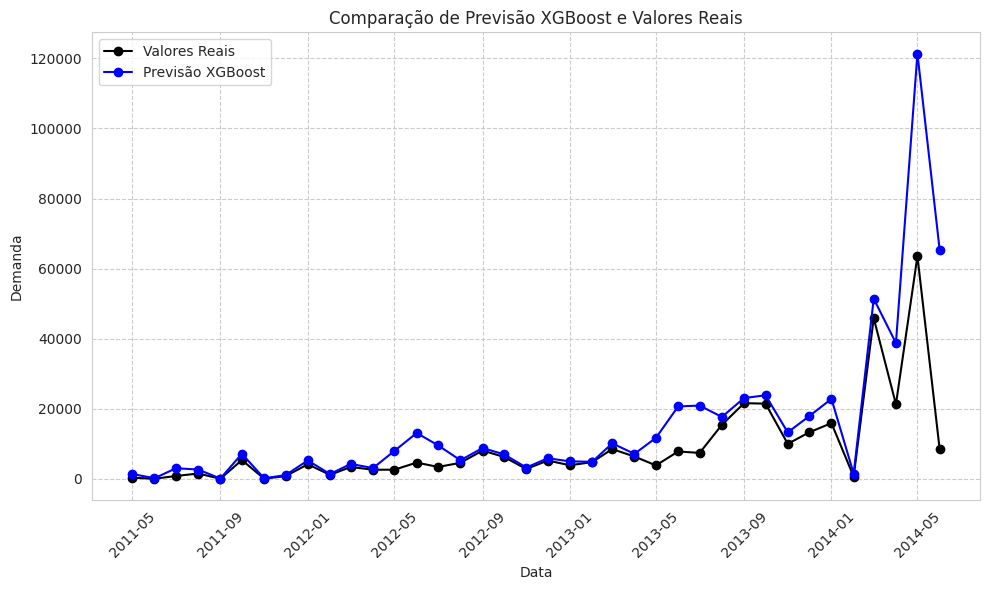

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(grouped_pred['year_month'],
         grouped_pred['y'],
         label='Valores Reais',
         linestyle='-',
         marker='o',
         color='black')

plt.plot(grouped_pred['year_month'],
         grouped_pred['y_pred'],
         label='Previsão XGBoost',
         linestyle='-',
         marker='o',
         color='blue')

plt.title('Comparação de Previsão XGBoost e Valores Reais')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
df_temp = predicts.copy()
df_temp['ds'] = pd.to_datetime(df_temp['ds'])

temp_grouped = df_temp.groupby(df_temp['ds'].dt.to_period('M')).agg({
    'y': 'sum',
    'AutoARIMA': 'sum',
    'Naive': 'sum'
}).reset_index()

temp_grouped['ds'] = temp_grouped['ds'].dt.to_timestamp()

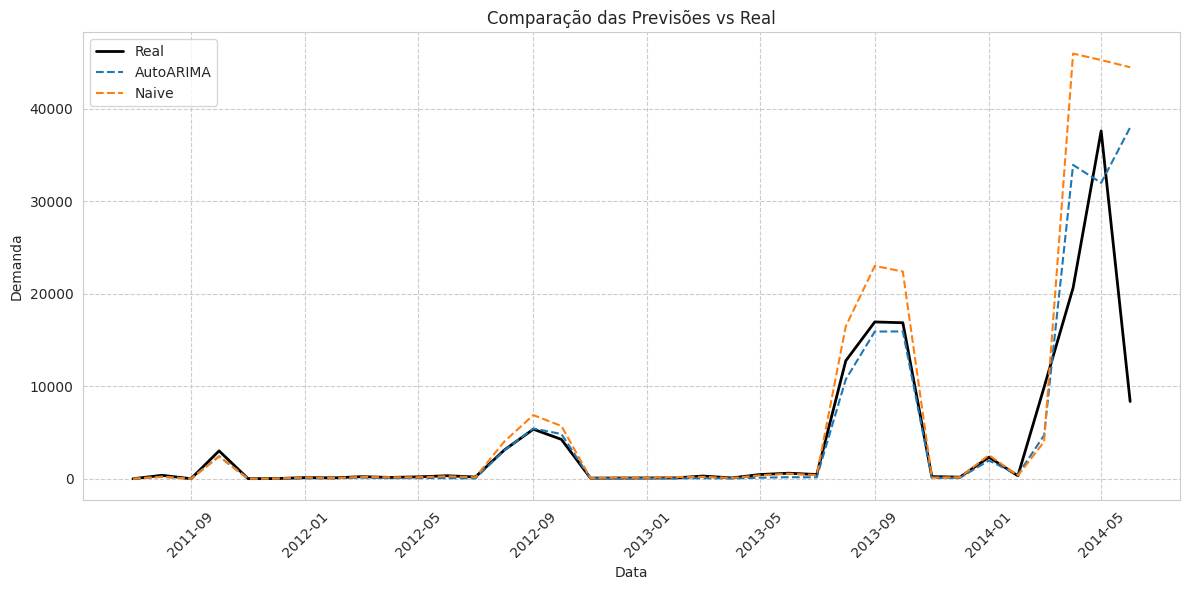

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(temp_grouped['ds'],
         temp_grouped['y'],
         label='Real',
         color='black',
         linestyle='-',
         linewidth=2)

# Plotar as previsões de cada modelo
plt.plot(temp_grouped['ds'], temp_grouped['AutoARIMA'], label='AutoARIMA', linestyle='--')
plt.plot(temp_grouped['ds'], temp_grouped['Naive'], label='Naive', linestyle='--')

plt.title('Comparação das Previsões vs Real')
plt.xlabel('Data')
plt.ylabel('Demanda')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Métricas do XGBoost
mae_xgb = mae(y_test1, y_pred_xgb)
mse_xgb = mse(y_test1, y_pred_xgb)
rmse_xgb = rmse(y_test1, y_pred_xgb)
mape_xgb = mape(y_test1, y_pred_xgb)

comparison_xgb = pd.DataFrame({
    'Model': ['XGBoostRegressor'],
    'MAE': [mae_xgb],
    'MSE': [mse_xgb],
    'RMSE': [rmse_xgb],
    'MAPE': [mape_xgb]
})

# Métricas Naive e AutoARIMA
y_true = temp_grouped['y']
y_pred_naive = temp_grouped['Naive']
y_pred_auto = temp_grouped['AutoARIMA']

mae_auto = mae(y_true, y_pred_auto)
mse_auto = mse(y_true, y_pred_auto)
rmse_auto = rmse(y_true, y_pred_auto)
mape_auto = mape(y_true, y_pred_auto)

mae_naive = mae(y_true, y_pred_naive)
mse_naive = mse(y_true, y_pred_naive)
rmse_naive = rmse(y_true, y_pred_naive)
mape_naive = mape(y_true, y_pred_naive)

comparison_auto = pd.DataFrame({
    'Model': ['AutoARIMA'],
    'MAE': [mae_auto],
    'MSE': [mse_auto],
    'RMSE': [rmse_auto],
    'MAPE': [mape_auto]
})

comparison_naive = pd.DataFrame({
    'Model': ['Naive'],
    'MAE': [mae_naive],
    'MSE': [mse_naive],
    'RMSE': [rmse_naive],
    'MAPE': [mape_naive]
})

display(comparison_xgb)
display(comparison_auto)
display(comparison_naive)

,Model,MAE,MSE,RMSE,MAPE
0,XGBoostRegressor,5.541837,3547.100993,59.557544,1.821512


,Model,MAE,MSE,RMSE,MAPE
0,AutoARIMA,1728.696061,3.109015e+07,5575.854069,0.520468


,Model,MAE,MSE,RMSE,MAPE
0,Naive,2665.25,5.904928e+07,7684.352685,0.369889
